# 学习率衰减

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
from utils import resnet
from torchvision import transforms as tfs
from datetime import datetime

In [2]:
net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-4)

In [26]:
print('learning rate: {}'.format(optimizer.param_groups[0]['lr']))
print('weight decay: {}'.format(optimizer.param_groups[0]['weight_decay']))

learning rate: 0.01
weight decay: 0.0001


In [29]:
optimizer.param_groups[0]['lr'] = 1e-5

In [30]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-1

In [3]:
def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [4]:
# 使用数据增强
def train_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(120),
        tfs.RandomHorizontalFlip(),
        tfs.RandomCrop(96),
        tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

def test_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(96),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

train_set = CIFAR10('./data', train=True, transform=train_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=4)
valid_set = CIFAR10('./data', train=False, transform=test_tf)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=False, num_workers=4)

net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [5]:
train_losses = []
valid_losses = []

if torch.cuda.is_available():
    net = net.cuda()
prev_time = datetime.now()
for epoch in range(30):
    if epoch == 20:
        set_learning_rate(optimizer, 0.01) # 80 次修改学习率为 0.01
    train_loss = 0
    net = net.train()
    for im, label in train_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda())  # (bs, 3, h, w)
            label = Variable(label.cuda())  # (bs, h, w)
        else:
            im = Variable(im)
            label = Variable(label)
        # forward
        output = net(im)
        loss = criterion(output, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "Time %02d:%02d:%02d" % (h, m, s)
    valid_loss = 0
    valid_acc = 0
    net = net.eval()
    for im, label in valid_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda(), volatile=True)
            label = Variable(label.cuda(), volatile=True)
        else:
            im = Variable(im, volatile=True)
            label = Variable(label, volatile=True)
        output = net(im)
        loss = criterion(output, label)
        valid_loss += loss.data[0]
    epoch_str = (
        "Epoch %d. Train Loss: %f, Valid Loss: %f, "
        % (epoch, train_loss / len(train_data), valid_loss / len(valid_data)))
    prev_time = cur_time
    
    train_losses.append(train_loss / len(train_data))
    valid_losses.append(valid_loss / len(valid_data))
    print(epoch_str + time_str)

Epoch 0. Train Loss: 1.872896, Valid Loss: 1.798441, Time 00:00:26
Epoch 1. Train Loss: 1.397522, Valid Loss: 1.421618, Time 00:00:28
Epoch 2. Train Loss: 1.129362, Valid Loss: 1.487882, Time 00:00:28
Epoch 3. Train Loss: 0.962217, Valid Loss: 2.095880, Time 00:00:28
Epoch 4. Train Loss: 0.859332, Valid Loss: 1.686056, Time 00:00:27
Epoch 5. Train Loss: 0.786428, Valid Loss: 1.348701, Time 00:00:27
Epoch 6. Train Loss: 0.730535, Valid Loss: 1.568454, Time 00:00:27
Epoch 7. Train Loss: 0.682074, Valid Loss: 1.230555, Time 00:00:28
Epoch 8. Train Loss: 0.643144, Valid Loss: 0.878328, Time 00:00:27
Epoch 9. Train Loss: 0.609817, Valid Loss: 0.869068, Time 00:00:27
Epoch 10. Train Loss: 0.585312, Valid Loss: 0.794440, Time 00:00:27
Epoch 11. Train Loss: 0.553877, Valid Loss: 1.900850, Time 00:00:27
Epoch 12. Train Loss: 0.526790, Valid Loss: 0.752651, Time 00:00:27
Epoch 13. Train Loss: 0.505155, Valid Loss: 1.112544, Time 00:00:27
Epoch 14. Train Loss: 0.486104, Valid Loss: 0.942357, Time

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

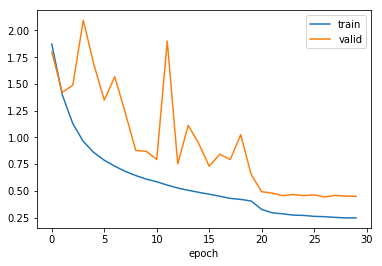

In [9]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epoch')
plt.legend(loc='best')